# Exercise 1

In [60]:
using Toms566

### Declare some useful subfunctions

In [61]:
# Convert the Toms566.Problem Type to the objective function format
function p2obj(p::Toms566.Problem)
    function obj(x)
        return (p.obj(x), p.grd(x), p.hes(x))
    end
    return obj
end

# Modified Newton method
# Modify the eigenvalues to be positive
function BkFunInv(H, ε)
    D, V = eig(H)
    Dp = ifelse(D .> ε, D, ε)
    Dpinv = 1./Dp
    return V * Diagonal(Dpinv) * V'
end

# Back tracking method
function backTracking(obj, x, d, g)
    α = 1
    while (obj(x + α*d)[1] > obj(x)[1] + α * 1e-4 * dot(g, d) || 
        dot(d, obj(x + α*d)[2]) < 0.9 * dot(d, g))
       α = α * 0.5 
       if α < 1e-7
           break
       end
    end
    return α
end

backTracking (generic function with 1 method)

### The Newton method

In [85]:
# Newton Method
function newtmin(obj, x0; maxIts=1000, optTol=1e-6, BkFlag = true, btFlag = true)
    # Minimize a function f using Newton’s method.
    # obj: a function that evaluates the objective value,
    # gradient, and Hessian at a point x, i.e.,
    # (f, g, H) = obj(x)
    # x0: starting point.
    # maxIts (optional): maximum number of iterations.
    # optTol (optional): optimality tolerance based on
    # ||grad(x)|| <= optTol*||grad(x0)||
    # BkFlag (optional): true for doing Modified Hessian
    # btFlag (optional): true for doing Back Tracking
    f0, g0, H0 = obj(x0)
    its = 0
    Opt = Float64[]
    xkp = x0
    for i in 1:maxIts
        xk = xkp
        fk, gk, Hk = obj(xk)
        opt = norm(gk, 2)
        push!(Opt, opt)
        if opt < optTol*norm(g0)
            break
        end
        if BkFlag == true
            Bkinv = BkFunInv(Hk, 0.01)
            dk = Bkinv * (- gk)
        else
            dk = Hk \ (- gk)
        end
        if btFlag == true
            αk = backTracking(obj, xk, dk, gk)
        else
            αk = 1
        end
        xkp = xk + αk * dk
        its = its + 1
    end
    return xkp, its, Opt
end


newtmin (generic function with 1 method)

### The BFGS Newton’s method

In [86]:
function newtminBFGS(obj, x0; maxIts=1000, optTol=1e-6, btFlag=true)
    # Minimize a function f using BFGS Newton’s method.
    # obj: a function that evaluates the objective value,
    # gradient, and Hessian at a point x, i.e.,
    # (f, g, H) = obj(x)
    # x0: starting point.
    # maxIts (optional): maximum number of iterations.
    # optTol (optional): optimality tolerance based on
    # ||grad(x)|| <= optTol*||grad(x0)||
    # btFlag (optional): true for doing Back Tracking
    f0, g0, H0 = obj(x0)
    D, V = eig(H0)
    Hkp = V * Diagonal(map(x -> 1/max(x,1), D)) * V'
    its = 0
    Opt = Float64[]
    xkp = copy(x0)
    for i in 1:maxIts
        xk = copy(xkp)
        Hk = copy(Hkp)
        gk = obj(xk)[2]
        opt = norm(gk, 2)
        push!(Opt, opt)
        if opt < optTol*norm(g0)
            break
        end
        dk = Hk * (- gk)
        if btFlag == true
            αk = backTracking(obj, xk, dk, gk)
        else
            αk = 1
        end
        xkp = xk + αk * dk
        fkp, gkp, Hkp = obj(xkp)
        sk = xkp - xk
        yk = gkp - gk
        ρk = 1/(yk' * sk)[]
        Hkp = (eye(Hk) - ρk * sk * yk') * Hk * (eye(Hk) - ρk * yk * sk') + ρk * sk * sk'
        its = its + 1
    end
    return xkp, its
end

newtminBFGS (generic function with 1 method)

### Simple test function

$$
f(x) = (x_1 - 10)^2 + (x_2 - 20)^4
$$


In [64]:
# Simple test function
#
function simple_hello(x)
    f = (x[1] - 10)^2 + (x[2] - 20)^4
    g = [ 2*(x[1] - 10) , 4*(x[2] - 20)^3]
    H = [[2,0] [0, 4*3*(x[2] - 20)^2]]
    return f, g, H
end

simple_hello (generic function with 1 method)

### Test the simple test function
The solution should be $(x_1 = 10, x_2 = 20)$


In [65]:
newtmin(simple_hello, [100,100], optTol=1e-10, btFlag=false, BkFlag=false)

([10.0,20.036087439178605],19)

The Newton Method gives $(x_1 = 10.0, x_2 = 20.036)$.
It requires 19 steps to the tolerace 10e-10.

# Testing Newton methods with Toms566

In [87]:
function final_test()
    
    btFlag_v = Bool[0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    BkFlag_v = Bool[0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    
    @printf("%3s %12s %12s %10s %10s %12s %12s %4s\n",
    "No.", "f(x0)","|∇f(x0)|", "BackTrack" , "ModNewt" ,"f(x*)","|∇f(x*)|", "Its")
    for i = 1:18
    p = Problem(i)
    pans = newtmin(p2obj(p), p.x0, maxIts = 2000, btFlag=btFlag_v[i], BkFlag=BkFlag_v[i])
    @printf("%3i %12.2e %12.2e %10s %10s %12.2e %12.2e %4i\n",
                i, p.obj(p.x0), norm(p.grd(p.x0)), 
                btFlag_v[i], BkFlag_v[i],
                p.obj(pans[1]), norm(p.grd(pans[1])), pans[2]
    )
    end
end

final_test (generic function with 1 method)

In [88]:
final_test()

No.        f(x0)     |∇f(x0)|  BackTrack    ModNewt        f(x*)     |∇f(x*)|  Its
  1     2.50e+03     1.88e+03      false      false     4.10e-12     1.88e-05   32
  2     7.79e-01     2.55e+00       true       true     2.61e-01     1.30e-01 2000
  3     3.89e-06     7.45e-03      false      false     1.13e-08     9.70e-11    2
  4     1.14e+00     2.00e+04       true       true     2.37e-04     1.34e+01 2000
  5     1.03e+03     1.49e+02      false      false     4.95e-08     1.30e-04    7
  6     9.39e+10     1.01e+11      false      false     5.08e+03     6.78e+04   17
  7     3.00e+01     1.78e+02       true       true     5.44e+00     1.79e+01 2000
  8     5.45e+09     8.02e+07      false      false     4.78e+01     7.40e+01   11
  9     2.87e+05     3.28e+05      false      false     8.81e+01     3.05e-01  228
 10     1.00e+12     2.00e+06       true       true     7.06e-25     1.68e-06    8
 11     7.93e+06     2.14e+06       true       true     1.60e+06     4.85e+05 2000
 12 

## Result of the Newton methods

For problem 1, 3, 5, 6, 8, 9, 10, 16 and 17,
the algorithm converges (before the maxIts) within the optional tolerace.

For problem 1, 3, 5, 6, 8, and 9, only the most simple Newton's method is used, that is, with $\alpha = 1$ and no modified Hessian. For the remaining problems, $\alpha$ is searched with Backtracking with Wolfe's condition, and also the Hessian is modified so that all eigenvalues are positive.

For those problems reaching maxIts, some of the optimal values still look good (i.e. very small compared to initial values), for example, problem 4, 13 and 18.

# Testing BFGS methods with Toms566

In [89]:
function BFGS_test()
    @printf("%3s  %12s %12s %12s %12s %4s\n",
    "No.", "f(x0)","|∇f(x0)|", "f(x*)","|∇f(x*)|", "Its")
    for i = 1:18
    p = Problem(i)
    pans = newtminBFGS(p2obj(p), p.x0,  maxIts = 2000, btFlag=true)
    @printf("%3i %12.2e %12.2e %12.2e %12.2e %4i\n",
                i, p.obj(p.x0), norm(p.grd(p.x0)),
                p.obj(pans[1]), norm(p.grd(pans[1])), pans[2]
    )
    end
end

BFGS_test (generic function with 1 method)

In [90]:
BFGS_test()

No.         f(x0)     |∇f(x0)|        f(x*)     |∇f(x*)|  Its
  1     2.50e+03     1.88e+03     7.86e-10     1.05e-03   25
  2     7.79e-01     2.55e+00     1.94e-13     4.57e-07  106
  3     3.89e-06     7.45e-03     1.13e-08     6.98e-11    4
  4     1.14e+00     2.00e+04     1.19e-11     6.81e-03  144
  5     1.03e+03     1.49e+02     4.62e-03     8.78e-03 2000
  6     9.39e+10     1.01e+11     1.38e+03     1.00e+05   19
  7     3.00e+01     1.78e+02     6.21e-06     1.89e-05   70
  8     5.45e+09     8.02e+07     4.47e+01     7.04e+01   25
  9     2.87e+05     3.28e+05     8.81e+01     5.51e-01 2000
 10     1.00e+12     2.00e+06     1.27e-13     7.10e-01   26
 11     7.93e+06     2.14e+06     8.58e+04     8.53e-01   19
 12     1.21e+01     3.97e+01     5.19e-13     4.92e-07   32
 13     2.01e-03     5.30e-02     3.95e-06     5.22e-08   53
 14     4.84e+02     1.04e+03     8.71e-08     9.55e-04  218
 15     3.23e+03     1.78e+03     4.57e-06     9.33e-04  172
 16     1.42e+01     2.

### Result of BFGS

We can see that BFGS converges (stop before maxIts) in most of the problems: 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16 and 18. For those problems reaching maxIts, the optimal values are still small compared to initial values. Therefore, BFGS gives very good results, compared to the Newton methods previously.


# Exercise 2

In [74]:
# Loading data set
(rawdata, head) = readdlm("binary.csv", ',', header=true)
y = rawdata[:,1]
u = [ones(400,1) rawdata[:,2:3]]'

# Scale the data for steepest descent
us = copy(u)
us[2,:] = us[2,:] /400

1x400 Array{Float64,2}:
 0.95  1.65  2.0  1.6  1.3  1.9  1.4  …  1.15  1.55  1.4  1.15  1.75  1.5

In [75]:
# Objective function of the log likelihood
# It is used in the Newton methods algorithms

function logRegObj(x)
    fi = [ -(y[i] * (x'*u[:,i]) - log(1+exp(x'*u[:,i]))) for i = 1:400]
    f = sum(fi)[]
    wi = Float64[ -(y[i] - exp(x'*u[:,i])/(1+exp(x'*u[:,i])))[] for i = 1:400]
    g = zeros(3)
    for i = 1:400
        g = g + wi[i] * u[:,i]
    end
    h = zeros(3,3)
    for i = 1:400 
        h = h + (exp(dot(x,u[:,i]))/(1+exp(dot(x,u[:,i])))^2) * (u[:,i] * u[:,i]')
    end
    return f,g,h
end

logRegObj (generic function with 1 method)

In [82]:
# Steepest Descent Algorithm
# Same as last homework

function f(x) 
    ansi = [ -(y[i] * (x'*us[:,i]) - log(1+exp(x'*us[:,i]))) for i = 1:400]
    return sum(ansi)
end

function grad(x)
    wi = Float64[ -(y[i] - exp(x'*us[:,i])/(1+exp(x'*us[:,i])))[] for i = 1:400]
    ans = zeros(3)
    for i = 1:400
        ans = ans + wi[i] * us[:,i]
    end
    return ans
end

function gradDescent(x0, step_size, tol)
    H = zeros(3,3)
    for i = 1:400
       H = H + (us[:,i]) * (us[:,i])'
    end

    #(D,) = eig(H)
    #L = maximum(D)/4
    
    L = maximum(svd(H)[2])
    Opt = Float64[]
    α = (1/L)
    g0 = grad(x0)
    its = 0
    xnew = x0
    for i in 1:step_size
        xold = xnew
        xnew = xold - ifelse(i<step_size/2, α*2, α*1.1) * grad(xold)
        opt = norm(grad(xnew), 2)
        push!(Opt, opt)
        if opt < norm(g0, 2)*tol 
            break
        end
        its = its + 1
    end
    return xnew, its, Opt
end

gradDescent (generic function with 1 method)

# Compare the Newton methods and Steepest descent

In [91]:
# Simple Newton Method
@time (nt_xstar, nt_itr, nt_opt) = newtmin(logRegObj, [0,0,0], btFlag=false, BkFlag=false)

([-4.949378062066131,0.0026906835956323786,0.7546868558708361],4,[38940.776616838295,2648.186303516699,108.7300601057249,0.25787718370109325,1.4798686559762289e-6])

0.124229 seconds (212.42 k allocations: 11.163 MB, 7.01% gc time)


In [78]:
# Newton Method with Modifed Hessian and Back tracking.
@time (nt_xstar, nt_itr, nt_opt) = newtmin(logRegObj, [0,0,0])

([-4.94937806206612,0.002690683595632377,0.7546868558708332],4)

0.102748 seconds (524.48 k allocations: 27.648 MB, 5.61% gc time)


In [79]:
# BFGS Quasi-Newton Method
@time newtminBFGS(logRegObj, [0,0,0])

([-4.949377962777058,0.002690678758128348,0.7546875383267416],5)

0.147561 seconds (791.19 k allocations: 41.687 MB, 7.28% gc time)


In [83]:
# Steepest Descent
@time (gd_xstar, gd_itr, gd_opt) = gradDescent([0,0,0], 10000, 1e-6)

 18

([-4.428647025237037,1.026789804421279,0.6265653660835168],10000,[133.699,70.2084,38.2122,21.61,13.0652,8.9525,7.21514,6.57574,6.35785,6.28345  …  0.443627,0.443558,0.443489,0.44342,0.443351,0.443282,0.443214,0.443145,0.443076,0.443007])

.720568 seconds (248.18 M allocations: 12.705 GB, 10.91% gc time)


# Compare the performance

We can see that, all the Newton methods require only a few steps (4 or 5 steps) to satisfy the tolerace.
However, the steepest descent require more than 10000 steps.
Newton methods have much better performance.

INFO: Precompiling module PyPlot...
INFO: Recompiling stale cache file /Users/po/.julia/lib/v0.4/URIParser.ji for module URIParser.
INFO: Recompiling stale cache file /Users/po/.julia/lib/v0.4/SHA.ji for module SHA.
INFO: Recompiling stale cache file /Users/po/.julia/lib/v0.4/Colors.ji for module Colors.
INFO: Recompiling stale cache file /Users/po/.julia/lib/v0.4/FixedPointNumbers.ji for module FixedPointNumbers.
INFO: Recompiling stale cache file /Users/po/.julia/lib/v0.4/ColorTypes.ji for module ColorTypes.
INFO: Recompiling stale cache file /Users/po/.julia/lib/v0.4/Reexport.ji for module Reexport.
INFO: Recompiling stale cache file /Users/po/.julia/lib/v0.4/LaTeXStrings.ji for module LaTeXStrings.


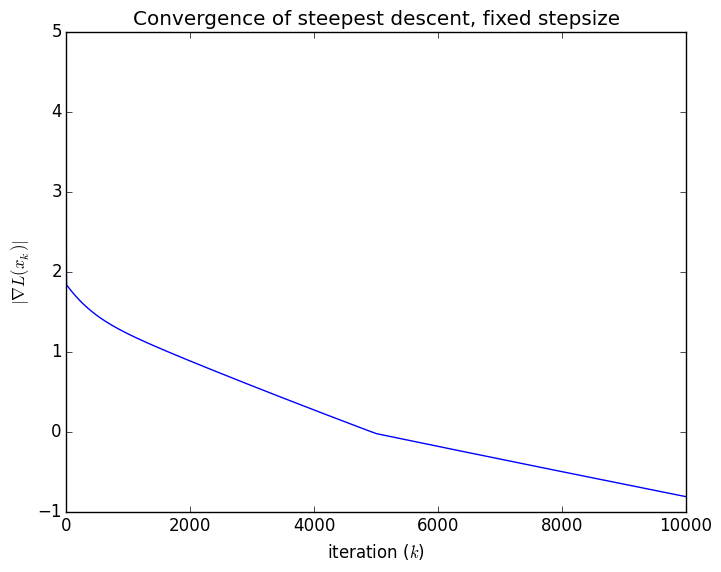

In [84]:
using PyPlot
plot(log(gd_opt))
title("Convergence of steepest descent, fixed stepsize")
xlabel(L"iteration ($k$)")
ylabel(L"$\|\nabla L(x_k)\|$");

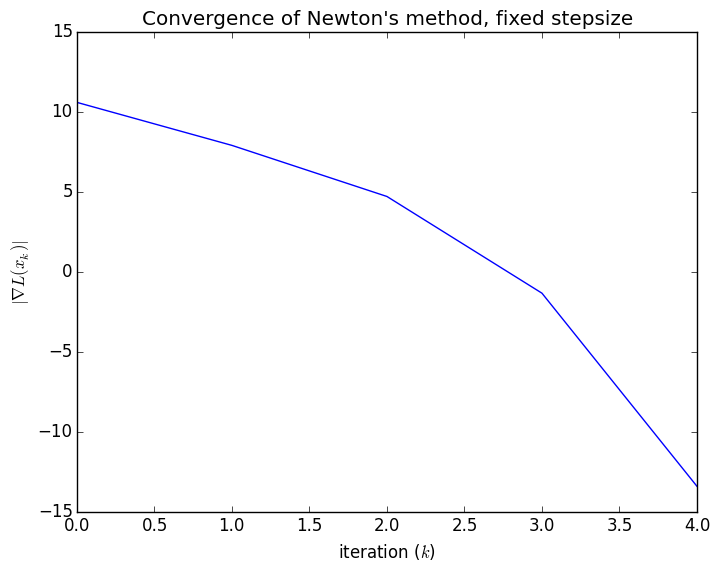

In [92]:
plot(log(nt_opt))
title("Convergence of Newton's method, fixed stepsize")
xlabel(L"iteration ($k$)")
ylabel(L"$\|\nabla L(x_k)\|$");